# Identifying Pediatric Patients with and without Pneumonia
* John Paul Hernandez Alcala 
* Part Time
* 10/03/2020 

## Libraries Used

In [1]:
#Kaggle Libraries
import os
from PIL import Image
print(os.listdir("../input"))

# Keras Libraries
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

import random
import cv2
import pandas as pd
import statistics 
import scipy.stats as stats
import seaborn as sns
from scipy.stats import pointbiserialr
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report
from sklearn.metrics import make_scorer, plot_confusion_matrix, precision_recall_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imPipeline
from imblearn.pipeline import make_pipeline as impipemaker
import time
%matplotlib inline

seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

import warnings
from datetime import datetime

warnings.filterwarnings('ignore')

['chest-xray-pneumonia']


## Data Science Lifecycle
Like with every project, we must first look to map for our data filled journey:
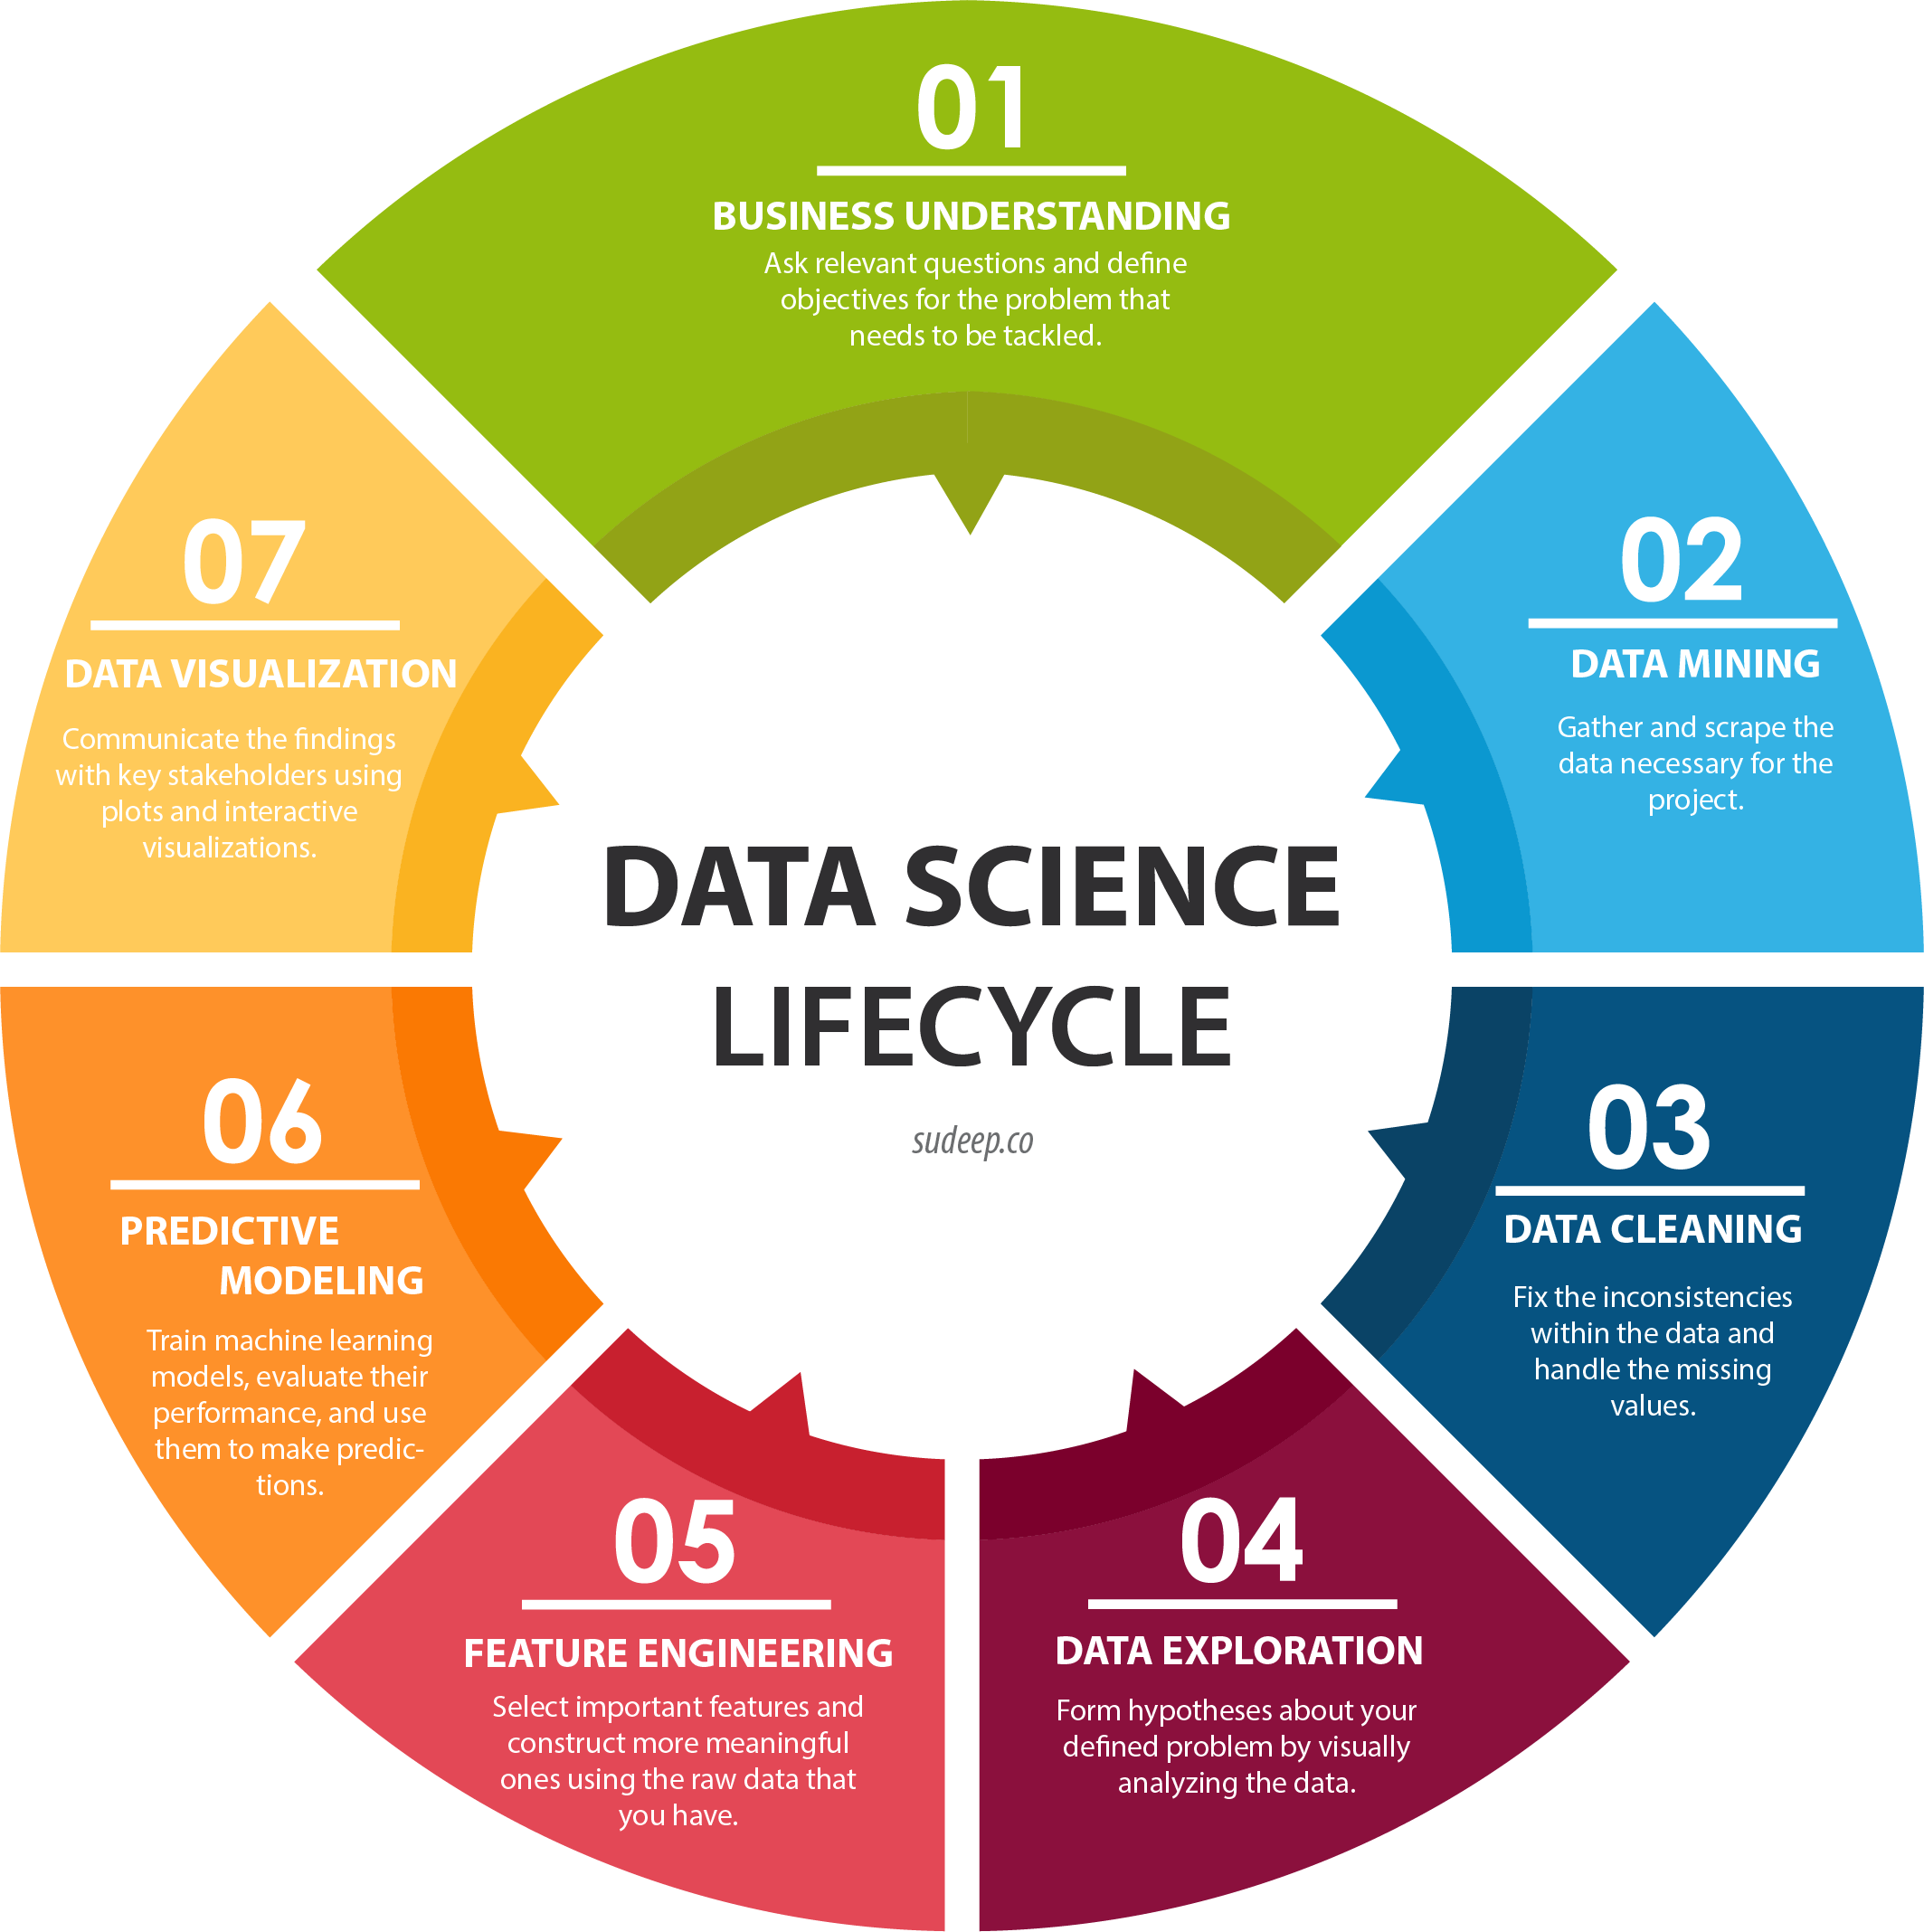

We use the above Data Science Lifecyle to structure and organize this project. In this project we will follow this structure. We will see, at times, these steps will be revisited.
# Business Understanding
From above, we see at "01" that we must obtain ask ourselves relevant questions and define objectives:

## Question
* "What is the main goal?"
    * **To identify whether or not pediatric patients have pneumonia**
* "Which predictors are used?"
    * **Since predictors are not completely obvious, a neural network will be used to engineer our features**

## Objectives
* Render a readme with a clear and well organized outline, conclusion and recommendation section. Visualizations are present.
* Present a business case constructed clearly and notebook contains 3 or more business recommendations that are supported by analysis.
* Explore different methods with benchmarking.
* Demonstrate explored methods with benchmarks.
* Present 3 or more visualizations are present in the notebook and visualizations are relevant to the project in a technical or business sense. 
* Compare multiple models that were in and outside class material.
* Design a live demo that changes parameters and shows the output.
* Code following pep-8 standards, with docstrings/comments, and does not repeat itself; also uses cusotm classes methods for tasks.
* Conclusion is present and contains at least 3 recommendations that are business relevant.

# Data Mining
Moving on to "02", we must gather the data necessary for this project. We will only be using data from [Paul Mooney](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) which has already been cleaned and processed. We add this data to our input folder.

## Importing Data
Below we set the input path and use it to access 6 of the images to get an idea of what they look like and the size of one image:

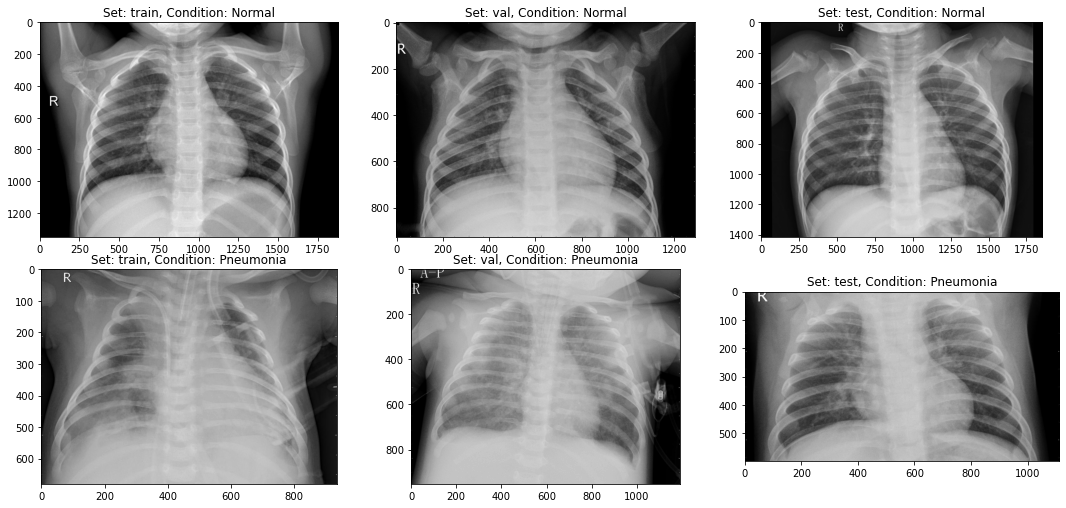

In [2]:
input_path = '../input/chest-xray-pneumonia//chest_xray/chest_xray/' #This makes it easier to call the data path

fig, ax = plt.subplots(2, 3, figsize=(15, 7)) #sets up the figure for displaying 2x3 matrix of images
ax = ax.ravel() # Return the flattened underlying data as an ndarray; in other words converts a 2x3 matrix axes into a 1-D list of axes
plt.tight_layout() #automatically adjusts subplot params so that the subplot(s) fits in to the figure area

for i, _set in enumerate(['train', 'val', 'test']): #sets up an array with i = [0,1,2] and another array _set = ['train', 'val', 'test']
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray') 
    #os.listdir returns a list containing the names of the entries in the directory given by path; in this case we pick the first entry
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[1]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))
    

In [3]:
plt.imread('../input/chest-xray-pneumonia//chest_xray/chest_xray/train'+'/PNEUMONIA/'+os.listdir('../input/chest-xray-pneumonia//chest_xray/chest_xray/train'+'/PNEUMONIA')[1]).shape

(680, 936)

In [4]:
folder = []
for i, _set in enumerate(['train', 'val', 'test']):
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    folder.append(input_path + _set)
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))
print(folder)

Set: train, normal images: 1342, pneumonia images: 3876
Set: val, normal images: 9, pneumonia images: 9
Set: test, normal images: 234, pneumonia images: 390
['../input/chest-xray-pneumonia//chest_xray/chest_xray/train', '../input/chest-xray-pneumonia//chest_xray/chest_xray/val', '../input/chest-xray-pneumonia//chest_xray/chest_xray/test']


NOTE: since this data set invovles images, we will not conduct data exploration since all of our feature engineering will be derived from training Convolution Neural Networks.
Since the image is black and white, we will build our model assuming these images are on the grayscale.
Below we split the data into train, test, and validation sets:

# Predictive Modeling
We move onto '06' which calls us to train a machine learning model, evalute its perforamnce, and use it to make predictions.

Before we move onto starting our model, we must initialize hyperparameters; these parameters are important for tweaking our model for the desired performance criterium. In this case, we want to reduce the amount of false negatives because a patient would go untreated when they actually had pneumonia. Therefore, we want the highest level of recall or True Positive/ (True Positive+False Positive).

* 'hyper_dimension': target image width and length in pixels considered when original images need to be rescaled for processing;
* 'hyper_epochs': number of epochs (leaning iterations through which the whole dataset is exposed to the machine for weight updates);
* 'hyper_batch_size': size of image batches;
* 'hyper_feature_maps': reference number of feature maps generated by convolutional layers;
* 'hyper_channels' and 'hyper_mode': number of channels utilized in the learning process. For colored RGB images, hyper_channels = 3 and hyper_mode = 'rgb', yet for grayscale images hyper_channels = 1 and hyper_mode = 'grayscale'.
* Specific considerations on hyperparameters are provided through the exercise.

## Intial Convolution Neural Network (CNN)
We will start with defining some hyperparameters (picked rather just randomly), then we will build our CNN, train it, and evuate its performance with an ROC-AUC Curve and confusion matrix. From here, we will change hyperparameters and see how it affects the performance. Lastly, we will figure out which model performance he best.


In [5]:
#Initializing hyperparameters
hyper_dimension = 100
hyper_epochs = 3
hyper_batch_size = 16
hyper_feature_maps = 32
hyper_channels = 1
hyper_mode = 'grayscale'
hyper_optimizer = 'adam'

In [6]:
# Initializing the CNN
cnn = Sequential()

#Convolution layer or Kernel/Filter will reduce dimensionality of our input image while
#extracting the high-level features
cnn.add(Conv2D(hyper_feature_maps, (3, 3), activation="relu", input_shape=(hyper_dimension,
                                                                           hyper_dimension,
                                                                           hyper_channels)))

#Pooling layer reduces the spatial size of the convolved feature which in turn decreases the
#Computational power required to process the data. Additionally extracts dominant features.
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd Convolution
cnn.add(Conv2D(hyper_feature_maps, (3, 3), activation="relu", input_shape=(hyper_dimension,
                                                                           hyper_dimension,
                                                                           hyper_channels)))

# 2nd Pooling layer
cnn.add(MaxPooling2D(pool_size = (2, 2)))


# After going through the above process, we have successfully enabled the model to understand 
#the features. 

# Flatten the layer, so we can feed it to a regular Neural Network for classification purposes
cnn.add(Flatten())

# Fully Connected Layers are a cheap way of learning non-linear combinations of the high-level 
# features as represented by the output of the convolutional layer
cnn.add(Dense(activation = 'relu', units = hyper_feature_maps))
cnn.add(Dense(activation = 'sigmoid', units = 1))

# Compile the Neural network
cnn.compile(optimizer = hyper_optimizer, loss = 'binary_crossentropy', metrics = [tf.keras.metrics.Recall()])

Note: we do a little data processing by rescaling, changing both the shear and zoom, and flipping the images

In [7]:
# Fitting the CNN to the images
# The function ImageDataGenerator augments your image by iterating through image as your CNN is getting ready to process that image

train_datagen = ImageDataGenerator(rescale = 1./255, #Image normalization.
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   vertical_flip = True)

val_datagen = ImageDataGenerator(rescale = 1./255) #Image normalization.

test_datagen = ImageDataGenerator(rescale = 1./255)  #Image normalization.



train_set = train_datagen.flow_from_directory(folder[0],
                                              target_size = (hyper_dimension,
                                                             hyper_dimension),
                                              batch_size = hyper_batch_size,
                                              class_mode = 'binary',
                                              color_mode = hyper_mode)

val_set = val_datagen.flow_from_directory(folder[1],
                                          target_size = (hyper_dimension,
                                                         hyper_dimension),
                                          batch_size = hyper_batch_size,
                                          class_mode = 'binary',
                                          color_mode = hyper_mode)

test_set = test_datagen.flow_from_directory(folder[2],
                                            target_size = (hyper_dimension,
                                                           hyper_dimension),
                                            batch_size = 1,
                                            class_mode = None,
                                            color_mode = hyper_mode,
                                            shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [8]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16928)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                541728    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

In [9]:
cnn_model = cnn.fit(train_set,
                    steps_per_epoch = len(train_set),
                    epochs = hyper_epochs,
                    validation_data = val_set,
                    validation_steps = len(val_set))

Epoch 1/3
326/326 [==============================] - 74s 227ms/step - loss: 0.3322 - recall: 0.9448 - val_loss: 0.5370 - val_recall: 0.7500
Epoch 2/3
326/326 [==============================] - 58s 176ms/step - loss: 0.2360 - recall: 0.9375 - val_loss: 0.5711 - val_recall: 1.0000
Epoch 3/3
326/326 [==============================] - 57s 176ms/step - loss: 0.2066 - recall: 0.9466 - val_loss: 0.4713 - val_recall: 0.8750


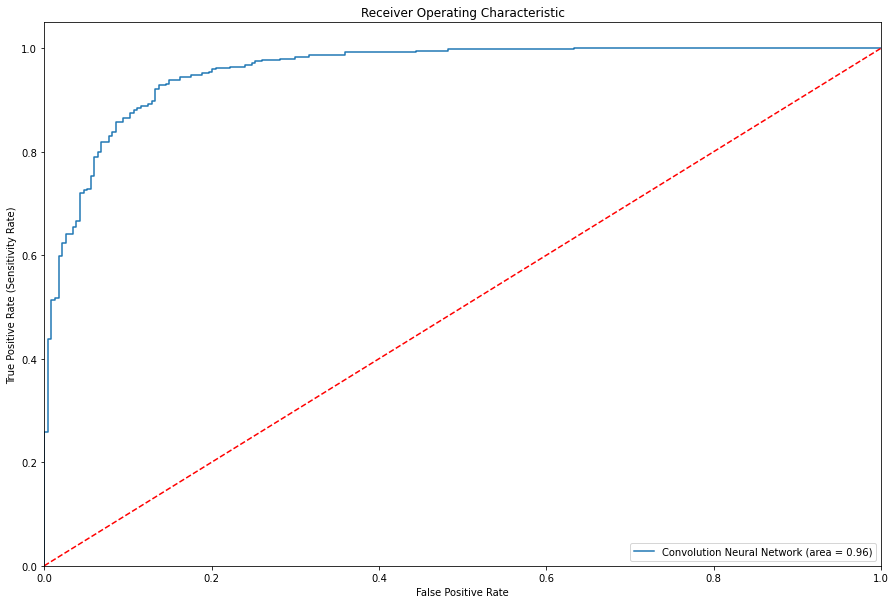

In [10]:
# Plotting ROC-AUC Curve
predictions = cnn.predict(test_set)
classes = test_set.classes

fpr_CNN, tpr_CNN, threshold_CNN = metrics.roc_curve(classes, predictions)
roc_auc_CNN = metrics.auc(fpr_CNN, tpr_CNN)

plt.figure(figsize=(15,10))
plt.plot(fpr_CNN, tpr_CNN, label='Convolution Neural Network (area = %0.2f)' % roc_auc_CNN)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('CNN_ROC')
plt.show()

In [11]:
# Confusion matrix

cm = pd.DataFrame(data=confusion_matrix(test_set.classes, cnn.predict_classes(test_set)),
                  index=["Actual Normal", "Actual Pneumonia"],
                  columns=["Predicted Normal", "Predicted Pneumonia"])
cm

,Predicted Normal,Predicted Pneumonia
Actual Normal,190,44
Actual Pneumonia,19,371


In [12]:
#Below will create a dataframe that will help visualize the sensitivity and accuracy for each threshold
results = pd.DataFrame()
thresholds = np.linspace(0.01, 1, num=50)
prec,sens, accu = [],[],[]
for t in thresholds:
    decisions = [1 if i>t else 0 for i in predictions]
    tn, fp, fn, tp = confusion_matrix(classes, decisions).ravel()
    sens.append(tp/(tp+fn))
    prec.append((tp)/(fp+tp))
    accu.append((tp+tn)/(fp+fn+tp+tn))
results['Threshold'] = thresholds
results['Sensitivity/Recall'] = sens
results['Specificity/Precision'] = prec
results['Accuracy'] = accu
results

,Threshold,Sensitivity/Recall,Specificity/Precision,Accuracy
0,0.010000,1.000000,0.625000,0.625000
1,0.030204,1.000000,0.662139,0.681090
2,0.050408,1.000000,0.700180,0.732372
3,0.070612,0.997436,0.727103,0.764423
4,0.090816,0.997436,0.752418,0.793269
5,0.111020,0.997436,0.771825,0.814103
6,0.131224,0.994872,0.779116,0.820513
7,0.151429,0.994872,0.783838,0.825321
8,0.171633,0.992308,0.801242,0.841346
9,0.191837,0.992308,0.814737,0.854167


The threshold value was selected because the accuracy is optimized. In the case where the true negative rate needs to be 100%, a threshold that will achieve that recall score should be selected.

In [13]:
# Select the thresholds that optimize accuracy
CNN_custom_threshold = [t for t in threshold_CNN if (t>=0.55) & (t<=0.70)]
CNN_custom_threshold

[0.6532882, 0.6319435, 0.60314643, 0.5946576]

In [14]:
threshold_CNN

array([1.9999998 , 0.99999976, 0.99999833, 0.9999981 , 0.9999069 ,
       0.99990547, 0.99987614, 0.99987423, 0.99960905, 0.99959403,
       0.9980782 , 0.99807054, 0.99670035, 0.9966709 , 0.9965869 ,
       0.9965088 , 0.99407023, 0.99382555, 0.99267524, 0.9922455 ,
       0.9911034 , 0.9907941 , 0.9892679 , 0.9889866 , 0.9883428 ,
       0.98783755, 0.98368084, 0.9836241 , 0.98288894, 0.9826172 ,
       0.9813976 , 0.98090565, 0.9773712 , 0.9772184 , 0.9651312 ,
       0.9634341 , 0.9629157 , 0.95722777, 0.95718724, 0.94986767,
       0.9495837 , 0.9474199 , 0.94535804, 0.936957  , 0.9337247 ,
       0.93286103, 0.9250242 , 0.9195666 , 0.9107686 , 0.90682167,
       0.8961677 , 0.8954786 , 0.88890064, 0.87634563, 0.8718485 ,
       0.8674695 , 0.86050355, 0.84819835, 0.84029526, 0.8311856 ,
       0.82672685, 0.8234111 , 0.7658161 , 0.7535925 , 0.7401954 ,
       0.7175135 , 0.715971  , 0.70151585, 0.67796135, 0.6532882 ,
       0.6319435 , 0.60314643, 0.5946576 , 0.539887  , 0.50121

In [15]:
# Find the index for each of the threshold values from the RF model
CNN_custom_threshold_index = [np.where(threshold_CNN == thr) for thr in CNN_custom_threshold ]
CNN_custom_threshold_index

[(array([69]),), (array([70]),), (array([71]),), (array([72]),)]

In [16]:
CNN_custom_threshold[0]

0.6532882

In [17]:
# Check them to make sure they are in their respective array
best_threshold= []
best_tpr = []
best_fpr = []
for idx in CNN_custom_threshold_index:
    print(threshold_CNN[idx], tpr_CNN[idx], 1-fpr_CNN[idx])
    best_threshold.append(threshold_CNN[idx])
    best_tpr.append(tpr_CNN[idx])
    best_fpr.append(fpr_CNN[idx])
best_threshold[0], best_tpr[0], best_fpr[0] ## Note: the last value is 1-specificity

[0.6532882] [0.93846154] [0.83760684]
[0.6319435] [0.94358974] [0.83760684]
[0.60314643] [0.94358974] [0.82478632]
[0.5946576] [0.94871795] [0.82478632]


(array([0.6532882], dtype=float32), array([0.93846154]), array([0.16239316]))

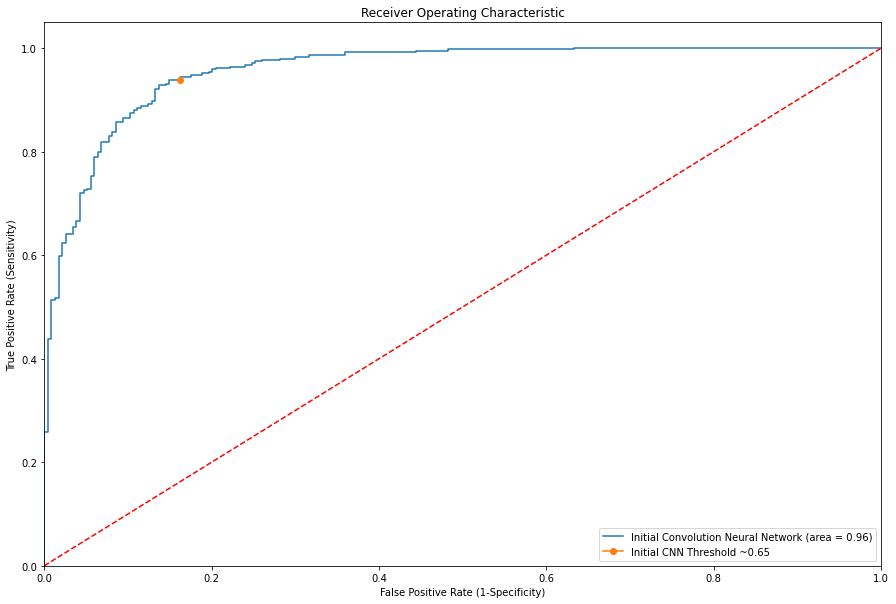

In [18]:
#Plot the best threshold on the plot
predictions = cnn.predict(test_set)
classes = test_set.classes

#Plot the ROC-CURVE
roc_auc_CNN = metrics.auc(fpr_CNN, tpr_CNN)

plt.figure(figsize=(15,10))
plt.plot(fpr_CNN, tpr_CNN, label='Initial Convolution Neural Network (area = %0.2f)' % roc_auc_CNN)
plt.plot(best_fpr[0], best_tpr[0], label='Initial CNN Threshold ~%0.2f' % best_threshold[0], marker='o')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('CNN_ROC')
plt.show()

In [19]:
predictions[predictions <= best_threshold[0]] = 0
predictions[predictions > best_threshold[0]] = 1

In [20]:
# Confusion matrix with threshold

cm = pd.DataFrame(data=confusion_matrix(test_set.classes, predictions),
                  index=["Actual Normal", "Actual Pneumonia"],
                  columns=["Predicted Normal", "Predicted Pneumonia"])
cm

,Predicted Normal,Predicted Pneumonia
Actual Normal,197,37
Actual Pneumonia,24,366


In [21]:
cnn_model.history

{'loss': [0.3321821391582489, 0.23604395985603333, 0.2065669149160385],
 'recall': [0.9447742104530334, 0.9375483989715576, 0.9465806484222412],
 'val_loss': [0.5370067358016968, 0.5710647106170654, 0.4712969660758972],
 'val_recall': [0.75, 1.0, 0.875]}

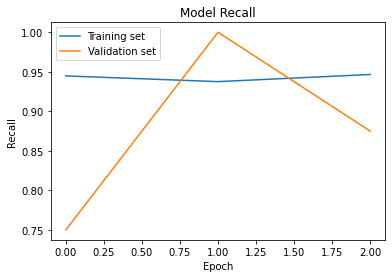

In [22]:
# Recall
plt.plot(cnn_model.history['recall'])
plt.plot(cnn_model.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()

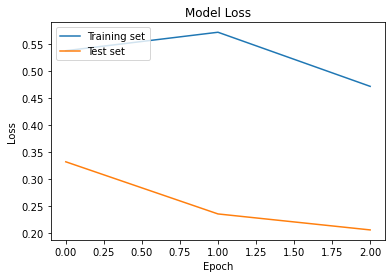

In [23]:
# Loss 

plt.plot(cnn_model.history['val_loss'])
plt.plot(cnn_model.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Test set'], loc='upper left')
plt.show()

## Second Model
In this model, we change the width and length to 500, and the number of epochs to 18.

In [29]:
#Initializing hyperparameters
hyper_dimension = 500 # changed to 500
hyper_epochs = 18 # changed to 100
hyper_batch_size = 16
hyper_feature_maps = 32
hyper_channels = 1
hyper_mode = 'grayscale'

In [30]:
# Initializing the CNN
cnn2 = Sequential()

#Convolution layer or Kernel/Filter that will reduce dimensionality of our input image while
#extracting the high-level features
cnn2.add(Conv2D(hyper_feature_maps, (3, 3), activation="relu", input_shape=(hyper_dimension,
                                                                           hyper_dimension,
                                                                           hyper_channels)))

#Pooling layer reduces the spatial size of the convolved feature which in turn decreases the
#Computational power requred to process the data. Additionally extracts dominant features.
cnn2.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd Convolution
cnn2.add(Conv2D(hyper_feature_maps, (3, 3), activation="relu", input_shape=(hyper_dimension,
                                                                           hyper_dimension,
                                                                           hyper_channels)))

# 2nd Pooling layer
cnn2.add(MaxPooling2D(pool_size = (2, 2)))


# After going through the above process, we have successfully enabled the model to understand 
#the features. 

# Flatten the layer, so we can feed it to a regular Neural Network for classification purposes
cnn2.add(Flatten())

# Fully Connected Layers are a cheap way of learning non-linear combinations of the high-level 
# features as represented by the output of the convolutional layer
cnn2.add(Dense(activation = 'relu', units = hyper_feature_maps))
cnn2.add(Dense(activation = 'sigmoid', units = 1))

# Compile the Neural network
cnn2.compile(optimizer = hyper_optimizer, loss = 'binary_crossentropy', metrics = [tf.keras.metrics.Recall()])

In [31]:
# Fitting the CNN to the images
# The function ImageDataGenerator augments your image by iterating through image as your CNN is getting ready to process that image

train_set = train_datagen.flow_from_directory(folder[0],
                                              target_size = (hyper_dimension,
                                                             hyper_dimension),
                                              batch_size = hyper_batch_size,
                                              class_mode = 'binary',
                                              color_mode = hyper_mode)

val_set = val_datagen.flow_from_directory(folder[1],
                                          target_size = (hyper_dimension,
                                                         hyper_dimension),
                                          batch_size = hyper_batch_size,
                                          class_mode = 'binary',
                                          color_mode = hyper_mode)

test_set = test_datagen.flow_from_directory(folder[2],
                                            target_size = (hyper_dimension,
                                                           hyper_dimension),
                                            batch_size = 1,
                                            class_mode = None,
                                            color_mode = hyper_mode,
                                            shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [32]:
cnn2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 498, 498, 32)      320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 249, 249, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 247, 247, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 123, 123, 32)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 484128)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                15492128  
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [33]:
cnn_model2 = cnn2.fit(train_set,
                    steps_per_epoch = len(train_set),
                    epochs = hyper_epochs,
                    validation_data = val_set,
                    validation_steps = len(val_set))

Epoch 1/18
326/326 [==============================] - 141s 433ms/step - loss: 0.4435 - recall_2: 0.9133 - val_loss: 0.5094 - val_recall_2: 0.8750
Epoch 2/18
326/326 [==============================] - 142s 437ms/step - loss: 0.2500 - recall_2: 0.9412 - val_loss: 0.6133 - val_recall_2: 0.7500
Epoch 3/18
326/326 [==============================] - 144s 441ms/step - loss: 0.2210 - recall_2: 0.9422 - val_loss: 0.7595 - val_recall_2: 0.8750
Epoch 4/18
326/326 [==============================] - 145s 444ms/step - loss: 0.2068 - recall_2: 0.9528 - val_loss: 0.7800 - val_recall_2: 0.8750
Epoch 5/18
326/326 [==============================] - 144s 442ms/step - loss: 0.2002 - recall_2: 0.9510 - val_loss: 0.6153 - val_recall_2: 0.7500
Epoch 6/18
326/326 [==============================] - 143s 439ms/step - loss: 0.1898 - recall_2: 0.9520 - val_loss: 0.6585 - val_recall_2: 0.7500
Epoch 7/18
326/326 [==============================] - 139s 426ms/step - loss: 0.1984 - recall_2: 0.9505 - val_loss: 0.4997 -

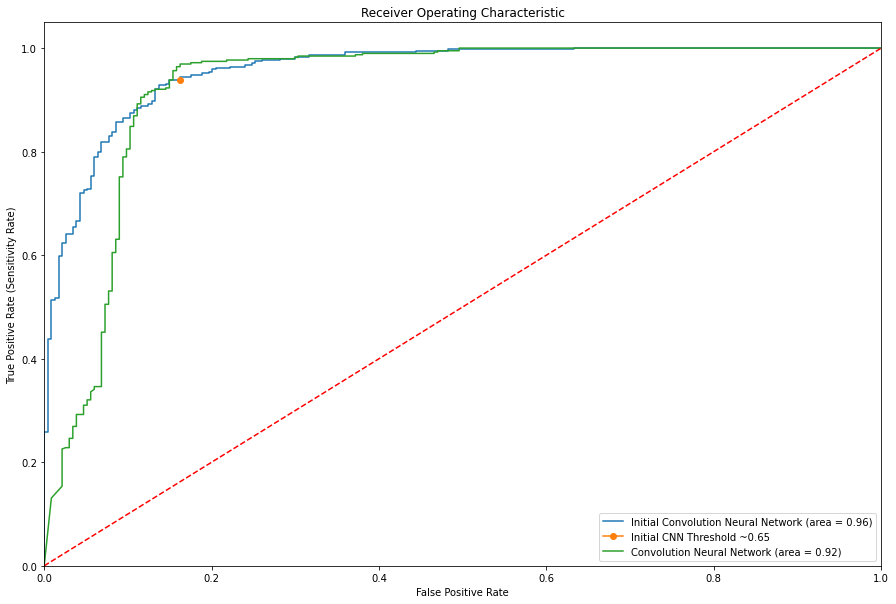

In [36]:
# Plotting ROC-AUC Curve
predictions2 = cnn2.predict(test_set)
classes = test_set.classes

fpr_CNN2, tpr_CNN2, threshold_CNN = metrics.roc_curve(classes, predictions2)
roc_auc_CNN2 = metrics.auc(fpr_CNN2, tpr_CNN2)

plt.figure(figsize=(15,10))
plt.plot(fpr_CNN, tpr_CNN, label='Initial Convolution Neural Network (area = %0.2f)' % roc_auc_CNN)
plt.plot(best_fpr[0], best_tpr[0], label='Initial CNN Threshold ~%0.2f' % best_threshold[0], marker='o')
plt.plot(fpr_CNN2, tpr_CNN2, label='Convolution Neural Network (area = %0.2f)' % roc_auc_CNN2)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Sensitivity Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('CNN_ROC')
plt.show()

In [37]:
# Confusion matrix

cm2 = pd.DataFrame(data=confusion_matrix(test_set.classes, cnn2.predict_classes(test_set)),
                  index=["Actual Normal", "Actual Pneumonia"],
                  columns=["Predicted Normal", "Predicted Pneumonia"])
cm2

,Predicted Normal,Predicted Pneumonia
Actual Normal,166,68
Actual Pneumonia,8,382


In [38]:
#Below will create a dataframe that will help visualize the sensitivity and accuracy for each threshold
results = pd.DataFrame()
thresholds = np.linspace(0.01, 1, num=50)
prec, sens, accu = [],[],[]
for t in thresholds:
    decisions = [1 if i>t else 0 for i in predictions2]
    tn, fp, fn, tp = confusion_matrix(classes, decisions).ravel()
    sens.append(tp/(tp+fn))
    prec.append((tp)/(fp+tp))
    accu.append((tp+tn)/(fp+fn+tp+tn))
results['Threshold'] = thresholds
results['Sensitivity/Recall'] = sens
results['Specificity/Precision'] = prec
results['Accuracy'] = accu
results

,Threshold,Sensitivity/Recall,Specificity/Precision,Accuracy
0,0.010000,1.000000,0.638298,0.645833
1,0.030204,1.000000,0.677083,0.701923
2,0.050408,1.000000,0.703971,0.737179
3,0.070612,1.000000,0.718232,0.754808
4,0.090816,1.000000,0.733083,0.772436
5,0.111020,1.000000,0.747126,0.788462
6,0.131224,1.000000,0.763209,0.806090
7,0.151429,1.000000,0.769231,0.812500
8,0.171633,0.997436,0.770297,0.812500
9,0.191837,0.992308,0.780242,0.820513


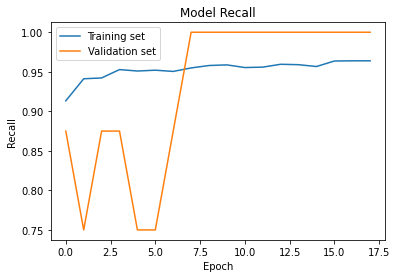

In [39]:
# Recall
plt.plot(cnn_model2.history['recall_2'])
plt.plot(cnn_model2.history['val_recall_2'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()

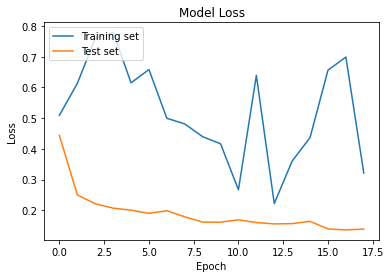

In [40]:
# Loss 

plt.plot(cnn_model2.history['val_loss'])
plt.plot(cnn_model2.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Test set'], loc='upper left')
plt.show()

## Conclusion
From the above, we see that the best model is the second model because it has the least amount of loss and high recall. With this model and our total analysis, we can produce three business recommendations:

1. **Paves the way for efficient diagnosis**
2. **Allows for quick insurance validation**
3. **Promotes accessibility to high quality medical care**

Now that we have proposed our three business recommendations, we know there are ways we can improve our current model. We can use drop rate and different optimizers which change weights and learning rate in order to reduce the losses. We can build a model that has more than 2 layers so more features can be extracted. Finally, we can get more data to train and test against our current model which will allows us to work towards a better model.

## References:
1. Convolution Guide: https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53
2. https://keras.io/api/layers/convolution_layers/convolution2d/
3. Comparing activation functions: 
https://towardsdatascience.com/exploring-activation-functions-for-neural-networks-73498da59b02
https://github.com/shudima/notebooks/blob/master/Activation%20Functions.ipynb
4. Optimization functions: https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a
https://towardsdatascience.com/optimizers-for-training-neural-network-59450d71caf6
5. helpful starting guides https://www.kaggle.com/sanwal092/intro-to-cnn-using-keras-to-predict-pneumonia
https://www.kdnuggets.com/2020/06/deep-learning-detecting-pneumonia-x-ray-images.html
6. ROC Curves with Keras: https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/

        